In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
import os
os.chdir('/content/drive/MyDrive/mask_detection')

In [4]:
!pwd

/content/drive/MyDrive/mask_detection


In [ ]:
# !unzip data.zip

In [5]:
import os
len(os.listdir('data'))
os.listdir('data')

['test', 'train']

In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/mask_detection')
!pwd

/content/drive/MyDrive/mask_detection


In [ ]:
# !git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.


In [6]:
!nvidia-smi

Sat Jan 14 06:39:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D
#from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.applications.resnet import ResNet101,preprocess_input
# from keras.applications.resnet_v2 import ResNet101V2,preprocess_input
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [9]:
# resizing images

image_size=[224,224]

train_path='/content/drive/MyDrive/mask_detection/data/train'
valid_path='/content/drive/MyDrive/mask_detection/data/test'

In [10]:
# adding preprocessing layer in front of VGG

mobilenet=MobileNet(input_shape=image_size+[3],weights='imagenet',include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
# d'nt train existing weights

for layer in mobilenet.layers:
  layer.trainable=False

In [12]:
# finding number of classes

folders=glob('/content/drive/MyDrive/mask_detection/data/train/*')
folders

['/content/drive/MyDrive/mask_detection/data/train/with_mask',
 '/content/drive/MyDrive/mask_detection/data/train/without_mask']

In [13]:
x=Flatten()(mobilenet.output)
prediction=Dense(len(folders),activation='sigmoid')(x)

In [14]:
model=Model(inputs=mobilenet.input,outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [16]:
# Compiling the model

model.compile(loss='binary_crossentropy',optimizer='adamax',metrics=['accuracy'])

In [17]:
train_datagen=ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1/255)

In [18]:
training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/mask_detection/data/train',target_size=(224,224),batch_size=10,class_mode='categorical')
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/mask_detection/data/train',target_size=(224,224),batch_size=10)

Found 6186 images belonging to 2 classes.
Found 6186 images belonging to 2 classes.


In [19]:
r=model.fit_generator(training_set,validation_data=test_set,epochs=5,steps_per_epoch=len(training_set),validation_steps=len(test_set))

<ipython-input-19-813583b8a56c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r=model.fit_generator(training_set,validation_data=test_set,epochs=5,steps_per_epoch=len(training_set),validation_steps=len(test_set))


Epoch 1/5
619/619 [==============================] - 723s 1s/step - loss: 0.0571 - accuracy: 0.9880 - val_loss: 0.0100 - val_accuracy: 0.9973
Epoch 2/5
619/619 [==============================] - 103s 167ms/step - loss: 0.0192 - accuracy: 0.9961 - val_loss: 0.0063 - val_accuracy: 0.9985
Epoch 3/5
619/619 [==============================] - 103s 167ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 4/5
619/619 [==============================] - 108s 175ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 0.9997
Epoch 5/5
619/619 [==============================] - 103s 166ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9997


In [20]:
print(r.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


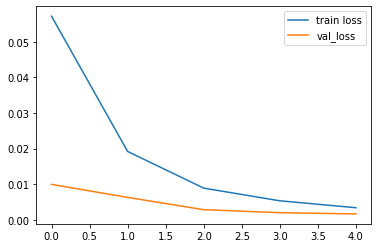

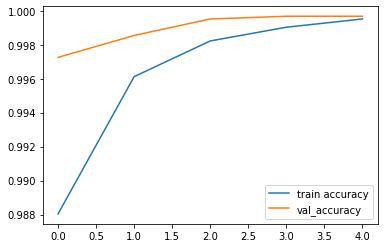

<Figure size 432x288 with 0 Axes>

In [21]:
# plotting loss and accuracy

## loss
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


## Accuracies
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...
